# Ungraded Lab: First DCGAN

## Disable Warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

## Imports

In [2]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

E0000 00:00:1722423644.380977      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D0731 11:00:44.389406475      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D0731 11:00:44.389423324      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D0731 11:00:44.389426978      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D0731 11:00:44.389429488      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D0731 11:00:44.389431984      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

## Utilities

In [3]:
def plot_results(images, n_cols=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)  

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

## Download and Prepare the Dataset

In [4]:
# download the training images
(X_train, _), _ = keras.datasets.fashion_mnist.load_data()

# normalize pixel values
X_train = X_train.astype(np.float32) / 255

# reshape and rescale
X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

BATCH_SIZE = 128

# create batches of tensors to be fed into the model
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


I0000 00:00:1722423660.622885      13 service.cc:145] XLA service 0x5940b727a540 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722423660.622946      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1722423660.622951      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1722423660.622954      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1722423660.622957      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1722423660.622960      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1722423660.622962      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1722423660.622965      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1722423660.622968      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


## Build the Model

### Generator

In [5]:
codings_size = 32

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])

generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6272)           │       206,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 414,209 (1.58 MB)

 Trainable params: 413,825 (1.58 MB)

 Non-trainable params: 384 (1.50 KB)

shape of the generated batch: (16, 28, 28, 1)


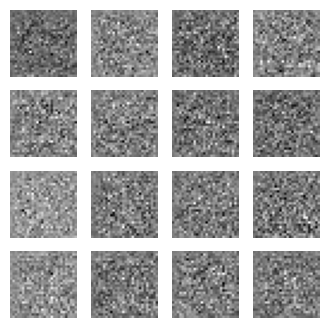

In [6]:
# generate a batch of noise input (batch size = 16)
test_noise = tf.random.normal([16, codings_size])

# feed the batch to the untrained generator
test_image = generator(test_noise)

# visualize sample output
plot_results(test_image, n_cols=4)

print(f'shape of the generated batch: {test_image.shape}')

## Discriminator

In [7]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
gan = keras.models.Sequential([generator, discriminator])

## Configure the Model for training

In [9]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

## Train the Model

In [10]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        for real_images in dataset:
            # infer batch size from the training batch
            batch_size = real_images.shape[0]

            # Train the discriminator - PHASE 1
            # create the noise
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # use the noise to generate fake images
            fake_images = generator(noise)

            # create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis=0)

            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            # ensure that the discriminator is trainable
            discriminator.trainable = True

            # use train_on_batch to train the discriminator with the mixed images and the discriminator labels
            discriminator.train_on_batch(mixed_images, discriminator_labels)

            # Train the generator - PHASE 2
            # create a batch of noise input to feed to the GAN
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            
            # label all generated images to be "real"
            generator_labels = tf.constant([[1.]] * batch_size)

            # freeze the discriminator
            discriminator.trainable = False

            # train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)
        
        # plot the fake images used to train the discriminator
        plot_results(fake_images, 16)                     
        plt.show()

In [11]:
train_gan(gan, dataset, codings_size, 100)

Epoch 1/100


NotFoundError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/local/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/local/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/usr/local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/local/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/usr/local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/usr/local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/usr/local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_13/2771751503.py", line 1, in <module>

  File "/tmp/ipykernel_13/998710628.py", line 35, in train_gan

  File "/usr/local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 544, in train_on_batch

  File "/usr/local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

could not find registered transfer manager for platform Host -- check target linkage
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_1204]